In [1]:
%matplotlib inline

In [2]:
cd ..

/home/mehdi2277/Documents/HarveyMuddWork/Neural_Nets_Research/neural_nets_research


In [3]:
from neural_nets_library import training

In [40]:
# A lot of inspiration from https://github.com/loudinthecloud/pytorch-ntm. Hyperparameters were chosen based
# upon his experiments.

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import random

In [5]:
def init_seed(seed=None):
    """Seed the RNGs for predicatability/reproduction purposes."""
    if seed is None:
        seed = int(get_ms() // 1000)

    print("Using seed=%d", seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

In [6]:
class NTM_Memory(nn.Module):
    def __init__(self, address_count, address_dimension, batch_size):
        super(NTM_Memory, self).__init__()
        self.initial_memory = nn.Parameter(torch.zeros(1, address_count, address_dimension))
        self.batch_size = batch_size
        
        self.reset_parameters()
        self.initialize_state()
    
    def reset_parameters(self):
        _, N, M = self.initial_memory.size()
        stdev = 1 / np.sqrt(N + M)
        nn.init.uniform(self.initial_memory, -stdev, stdev)
    
    def initialize_state(self):
        self.memory = self.initial_memory.repeat(self.batch_size, 1, 1)
    
    def address_memory(self, key_vec, prev_address_vec, β, g, s, γ):
        EPSILON = 1e-16
        result = F.cosine_similarity((key_vec+EPSILON).unsqueeze(1).expand_as(self.memory), 
                                     self.memory+EPSILON, dim = 2)
        result = F.softmax(β * result, dim=1)
        result = g * result + (1 - g) * prev_address_vec
        result = torch.cat((result[:, 1:], result[:, :1]), 1) * s[:, 0:1] + result * s[:, 1:2] + \
                 torch.cat((result[:, -1:], result[:, :-1]), 1) * s[:, 2:3]

#         result = result ** γ
#         result = result / (result.sum(1, keepdim=True) + EPSILON)
        
        return result
    
    def read_memory(self, address_vec):
        return torch.bmm(self.memory.transpose(1,2), address_vec.unsqueeze(2)).squeeze(2)
    
    def update_memory(self, address_vec, erase_vec, add_vec):
        self.memory = self.memory * (1 - torch.bmm(address_vec.unsqueeze(2), erase_vec.unsqueeze(1)))
        self.memory += torch.bmm(address_vec.unsqueeze(2), add_vec.unsqueeze(1))

In [7]:
def _split_cols(mat, lengths):
    """Split a 2D matrix to variable length columns."""
    assert mat.size()[1] == sum(lengths), "Lengths must be summed to num columns"
    l = np.cumsum([0] + lengths)
    results = []
    for s, e in zip(l[:-1], l[1:]):
        results += [mat[:, s:e]]
    return results

class NTM_Head(nn.Module):
    def __init__(self, address_count, address_dimension, 
                 controller_output_size):
        super(NTM_Head, self).__init__()
        
        self.controller_output_size = controller_output_size
        self.N = address_count
        self.M = address_dimension
    
    def is_read_head(self):
        raise NotImplementedError
    
    def reset_parameters(self):
        raise NotImplementedError
    
    def initialize_state(self):
        raise NotImplementedError

In [8]:
class NTM_Read_Head(NTM_Head):
    def __init__(self, address_count, address_dimension, controller_output_size, batch_size):
        super(NTM_Read_Head, self).__init__(address_count, address_dimension, controller_output_size)
        
        self.read_parameters_lengths = [self.M, 1, 1, 3, 1]
        self.fc_read_parameters = nn.Linear(controller_output_size, sum(self.read_parameters_lengths))
        
        self.batch_size = batch_size
        
        self.reset_parameters()
        self.initialize_state()
    
    def reset_parameters(self):
        nn.init.xavier_uniform(self.fc_read_parameters.weight, gain=1.4)
        nn.init.normal(self.fc_read_parameters.bias, std=0.01)
        
        self.initial_address_vec = nn.Parameter(torch.zeros(self.N))
        self.initial_read = nn.Parameter(torch.randn(1, self.M) * 0.01)
    
    def initialize_state(self):
        self.prev_address_vec = self.initial_address_vec.clone()
        self.prev_read = self.initial_read.repeat(self.batch_size, 1)
    
    def is_read_head(self):
        return True
    
    def forward(self, x, memory):
        read_parameters = self.fc_read_parameters(x)
        
        key_vec, β, g, s, γ = _split_cols(read_parameters, self.read_parameters_lengths)
        β = F.softplus(β)
        g = F.sigmoid(g)
        s = F.softmax(s, dim=1)
        γ = 1 + F.softplus(γ)
        
        self.prev_address_vec = memory.address_memory(key_vec, self.prev_address_vec, β, g, s, γ)
        new_read = memory.read_memory(self.prev_address_vec)        
        self.prev_read = new_read
        return new_read

In [9]:
class NTM_Write_Head(NTM_Head):
    def __init__(self, address_count, address_dimension, controller_output_size):
        super(NTM_Write_Head, self).__init__(address_count, address_dimension, controller_output_size)
        
        self.write_parameters_lengths = [self.M, 1, 1, 3, 1, self.M, self.M]
        self.fc_write_parameters = nn.Linear(controller_output_size, sum(self.write_parameters_lengths))
        
        self.reset_parameters()
        self.initialize_state()
    
    def reset_parameters(self):
        nn.init.xavier_uniform(self.fc_write_parameters.weight, gain=1.4)
        nn.init.normal(self.fc_write_parameters.bias, std=0.01)
        
        self.initial_address_vec = nn.Parameter(torch.zeros(self.N))
    
    def initialize_state(self):       
        self.prev_address_vec = self.initial_address_vec.clone()
    
    def is_read_head(self):
        return False
    
    def forward(self, x, memory):
        write_parameters = self.fc_write_parameters(x)
                                       
        key_vec, β, g, s, γ, erase_vec, add_vec = _split_cols(write_parameters, self.write_parameters_lengths)
        β = F.softplus(β)
        g = F.sigmoid(g)
        s = F.softmax(s, dim=1)
        γ = 1 + F.softplus(γ)
        erase_vec = F.sigmoid(erase_vec)
                                               
        self.prev_address_vec = memory.address_memory(key_vec, self.prev_address_vec, β, g, s, γ)
        memory.update_memory(self.prev_address_vec, erase_vec, add_vec)

In [10]:
class NTM(nn.Module):
    def __init__(self, batch_size, controller, controller_output_size, 
                 output_size, address_count, address_dimension, heads):
        super(NTM, self).__init__()
        
        self.batch_size = batch_size
        
        # Initialize controller
        self.controller = controller
        
        # Create output gate. No activation function is used with it because
        # I used BCEWithLogitsLoss which deals with the sigmoid in a more
        # numerically stable manner.
        self.outputGate = nn.Linear(controller_output_size, output_size)
        
        # Initialize memory
        self.memory = NTM_Memory(address_count, address_dimension, batch_size)

        # Construct the heads.
        self.heads = nn.ModuleList()
        
        for head_id in heads:
            if head_id == 0:
                self.heads.append(NTM_Read_Head(address_count, address_dimension, 
                                                controller_output_size, batch_size))
            else:
                self.heads.append(NTM_Write_Head(address_count, address_dimension,
                                                 controller_output_size))
        self.initialize_state()
        
    def initialize_state(self):
        self.prev_reads = []
        
        for head in self.heads:
            head.initialize_state()
            
            if head.is_read_head():
                self.prev_reads.append(head.prev_read)
        
        self.memory.initialize_state()
        
    def reset_parameters(self):
        nn.init.xavier_uniform(self.outputGate.weight)
        nn.init.normal(self.outputGate.bias, std=0.01)
        
    def forward(self, x):
        self.initialize_state()
        outputs = []
        
        for current_observation in x.transpose(0,1):
            self.prev_reads.append(current_observation)
            controller_input = torch.cat(self.prev_reads, 1)
            controller_output = self.controller(controller_input)

            self.prev_reads = []

            for head in self.heads:                
                if head.is_read_head():
                    self.prev_reads.append(head(controller_output, self.memory))
                else:
                    head(controller_output, self.memory)
                    
            current_output = self.outputGate(controller_output)
            outputs.append(current_output)
        
        return torch.stack(outputs).transpose(0, 1)

In [11]:
class CopyTaskDataset(data.Dataset):
    def __init__(self, num_batches, batch_size, lower, upper, seq_size):
        self.input_list = []
        self.label_list = []
        
        for _ in range(num_batches):
            data, label = self.generate_batch(batch_size, lower, upper, seq_size)
            self.input_list.append(data)
            self.label_list.append(label)
        
        self.batch_size = batch_size

    def generate_batch(self, batch_size, lower, upper, seq_size):
        seq_length = random.randint(lower, upper)
        label = torch.from_numpy(
                np.random.binomial(1, 0.5, (seq_length, batch_size, seq_size))).float()
        end_marker = torch.zeros(seq_length, batch_size, 1)
        seq = torch.cat((label, end_marker), 2)
        delimiter_column = torch.zeros(1, batch_size, seq_size+1)
        delimiter_column[0, :, seq_size] = 1
        seq = torch.cat((seq, delimiter_column), 0)
        output_time = torch.zeros(seq_length, batch_size, seq_size+1)
        seq = torch.cat((seq, output_time), 0)
        return seq, label
    
    def __len__(self):
        return len(self.input_list)*self.batch_size
    
    def __getitem__(self, i):
        batch_index = i//self.batch_size
        index_in_batch = i % self.batch_size
        return self.input_list[batch_index][:, index_in_batch, :], self.label_list[batch_index][:, index_in_batch, :]

In [12]:
class EncapsulatedLSTM(nn.Module):
    def __init__(self, batch_size, all_hiddens, *args, **kwargs):
        super(EncapsulatedLSTM, self).__init__()
        self.lstm = nn.LSTM(*args, **kwargs)
        self.all_hiddens = all_hiddens
        self.batch_size = batch_size
                
        self.num_inputs = args[0]
        self.hidden_size = args[1]
        self.num_layers = args[2]
        
        self.reset_parameters()
        self.initialize_state()
          
    def initialize_state(self):
        self.state_tuple = (self.initial_hidden_state.repeat(1, self.batch_size, 1), 
                            self.initial_cell_state.repeat(1, self.batch_size, 1))
    
    def reset_parameters(self):
        self.initial_hidden_state = nn.Parameter(torch.randn(self.num_layers, 1, self.hidden_size) * 0.05)
        self.initial_cell_state = nn.Parameter(torch.randn(self.num_layers, 1, self.hidden_size) * 0.05)
        
        for p in self.lstm.parameters():
            if p.dim() == 1:
                nn.init.constant(p, 0)
            else:
                stdev = 5 / (np.sqrt(self.num_inputs +  self.hidden_size))
                nn.init.uniform(p, -stdev, stdev)
        
    def forward(self, input):
        self.initialize_state()
        output, self.state_tuple = self.lstm(input.unsqueeze(0), self.state_tuple)
        
        if self.all_hiddens:
            return self.state_tuple[0].transpose(0,1).view(self.batch_size, -1)
        else:
            return output.squeeze(0)

In [13]:
def copy_task_loss(output, label):
    _, seq_length, _ = label.size()
    return F.binary_cross_entropy_with_logits(output[:, -seq_length:, :], label)

In [34]:
def error_bits_per_sequence(output, label):
    batch_size, seq_length, _ = label.size()
    binarized_output = output[:, -seq_length:, :].sign()/2 + 0.5
    
    # The cost is the number of error bits per sequence
    return torch.sum(torch.abs(binarized_output - label))/batch_size

In [15]:
# def construct_clipped_optimizer(optimizer_type):
#     class ClippedOptimizer(optimizer_type):
#         def step(self, closure=None):
#             for group in self.param_groups:
#                 for p in group['params']:
#                     if p.grad is not None:
#                         p.grad = p.grad.data.clamp(-10,10)
            
#             super().step(closure)
    
#     return ClippedOptimizer

In [16]:
# ClippedRMSprop = construct_clipped_optimizer(optim.RMSprop)

In [17]:
batch_size = 64
hidden_size = 100
num_layers = 3
seq_size = 8
address_size = 20
controller = EncapsulatedLSTM(batch_size, False, # all hiddens
                              seq_size + address_size + 1, hidden_size, 
                              num_layers)

In [35]:
address_count = 128
controller_output_size = hidden_size

ntm = NTM(batch_size, controller, controller_output_size, 
          seq_size, address_count, address_size, [0, 1])   

In [36]:
ntm = ntm.cuda()

In [37]:
lower_seq_length = 3
upper_seq_length = 10
num_batches = 10000

dataset = CopyTaskDataset(num_batches, batch_size, lower_seq_length, upper_seq_length, seq_size)
data_loader = data.DataLoader(dataset, batch_size=batch_size)

In [38]:
optimizer = optim.RMSprop(ntm.parameters(), momentum=0.9,
                          alpha=0.95, lr=1e-4)

In [39]:
best_model, train_plot_losses, validation_plot_losses = training.train_model(ntm, data_loader, copy_task_loss, optimizer, None, num_epochs=1, print_every=25, deep_copy_desired=False, validation_criterion=error_bits_per_sequence)

Epoch 0/0
----------
Epoch Number: 0, Batch Number: 25, Training Loss: 0.6938, Validation Loss: 24.5575
Time so far is 0m 4s
Epoch Number: 0, Batch Number: 50, Training Loss: 0.6822, Validation Loss: 23.3525
Time so far is 0m 9s
Epoch Number: 0, Batch Number: 75, Training Loss: 0.6435, Validation Loss: 15.4519
Time so far is 0m 13s
Epoch Number: 0, Batch Number: 100, Training Loss: 0.6426, Validation Loss: 19.9481
Time so far is 0m 17s
Epoch Number: 0, Batch Number: 125, Training Loss: 0.6264, Validation Loss: 19.1938
Time so far is 0m 22s
Epoch Number: 0, Batch Number: 150, Training Loss: 0.6099, Validation Loss: 17.3738
Time so far is 0m 27s
Epoch Number: 0, Batch Number: 175, Training Loss: 0.6079, Validation Loss: 18.1269
Time so far is 0m 30s
Epoch Number: 0, Batch Number: 200, Training Loss: 0.6080, Validation Loss: 17.5956
Time so far is 0m 34s
Epoch Number: 0, Batch Number: 225, Training Loss: 0.6169, Validation Loss: 20.2437
Time so far is 0m 38s
Epoch Number: 0, Batch Number:

Epoch Number: 0, Batch Number: 1975, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 6m 9s
Epoch Number: 0, Batch Number: 2000, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 6m 12s
Epoch Number: 0, Batch Number: 2025, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 6m 15s
Epoch Number: 0, Batch Number: 2050, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 6m 21s
Epoch Number: 0, Batch Number: 2075, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 6m 26s
Epoch Number: 0, Batch Number: 2100, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 6m 31s
Epoch Number: 0, Batch Number: 2125, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 6m 37s
Epoch Number: 0, Batch Number: 2150, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 6m 42s
Epoch Number: 0, Batch Number: 2175, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 6m 46s
Epoch Number: 0, Batch Number: 2200, Training L

Epoch Number: 0, Batch Number: 3925, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 12m 11s
Epoch Number: 0, Batch Number: 3950, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 12m 15s
Epoch Number: 0, Batch Number: 3975, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 12m 19s
Epoch Number: 0, Batch Number: 4000, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 12m 23s
Epoch Number: 0, Batch Number: 4025, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 12m 26s
Epoch Number: 0, Batch Number: 4050, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 12m 30s
Epoch Number: 0, Batch Number: 4075, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 12m 34s
Epoch Number: 0, Batch Number: 4100, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 12m 37s
Epoch Number: 0, Batch Number: 4125, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 12m 41s
Epoch Number: 0, Batch Number: 4150, 

Epoch Number: 0, Batch Number: 5850, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 17m 18s
Epoch Number: 0, Batch Number: 5875, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 17m 23s
Epoch Number: 0, Batch Number: 5900, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 17m 28s
Epoch Number: 0, Batch Number: 5925, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 17m 33s
Epoch Number: 0, Batch Number: 5950, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 17m 38s
Epoch Number: 0, Batch Number: 5975, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 17m 43s
Epoch Number: 0, Batch Number: 6000, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 17m 49s
Epoch Number: 0, Batch Number: 6025, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 17m 54s
Epoch Number: 0, Batch Number: 6050, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 17m 59s
Epoch Number: 0, Batch Number: 6075, 

Epoch Number: 0, Batch Number: 7775, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 22m 49s
Epoch Number: 0, Batch Number: 7800, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 22m 52s
Epoch Number: 0, Batch Number: 7825, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 22m 55s
Epoch Number: 0, Batch Number: 7850, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 22m 60s
Epoch Number: 0, Batch Number: 7875, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 23m 3s
Epoch Number: 0, Batch Number: 7900, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 23m 6s
Epoch Number: 0, Batch Number: 7925, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 23m 10s
Epoch Number: 0, Batch Number: 7950, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 23m 13s
Epoch Number: 0, Batch Number: 7975, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 23m 16s
Epoch Number: 0, Batch Number: 8000, Tr

Epoch Number: 0, Batch Number: 9700, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 27m 43s
Epoch Number: 0, Batch Number: 9725, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 27m 46s
Epoch Number: 0, Batch Number: 9750, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 27m 49s
Epoch Number: 0, Batch Number: 9775, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 27m 52s
Epoch Number: 0, Batch Number: 9800, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 27m 56s
Epoch Number: 0, Batch Number: 9825, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 27m 59s
Epoch Number: 0, Batch Number: 9850, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 28m 2s
Epoch Number: 0, Batch Number: 9875, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 28m 5s
Epoch Number: 0, Batch Number: 9900, Training Loss: 0.0000, Validation Loss: 0.0000
Time so far is 28m 8s
Epoch Number: 0, Batch Number: 9925, Tra

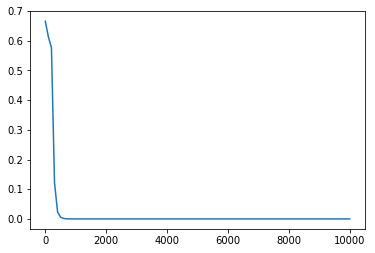

In [44]:
plt.plot(np.linspace(0, 10000, 100), train_plot_losses)
plt.show()

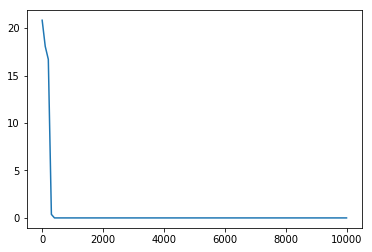

In [45]:
plt.plot(np.linspace(0, 10000, 100), validation_plot_losses)
plt.show()